# Dog.. pig.. dog.. pig.. loaf of bread?!?

I started playing with image recognition models recently and it started off very well.  The models I trained were able to easily (and confidently!) identify common pets or objects.  But what about something harder?  I wanted to see it break down so I could see what more training iterations or a large data set would do.  How can I do that easily?

It struck me.  I call it a moment of inspiration.  You might call it lunacy.  Either way, I was amused with the though.

Have you see the movie "The Mitchells vs The Machines"?  The dog Monchi is a pug and for whatever reason causes the dumber robots to explode because they can't figure out if he's a pig, dog, or loaf of bread.  Would this really confuse an AI?

In this blog I will walk through:
* The creation of a Red Hat OpenShift on AWS (ROSA) with Hosted Control Planes (HCP) cluster.
* Installation of Red Hat OpenShift Data Science.
* Creation of a Data Science Project and Workspace.
* Walking through the steps to download image data, train a model, and test if it works.
* And if it doesn't go well for the machines... change things to see if we can get a better result.

The notebook in this blog is based on the excellent [Practical Deep Learning for Coders](https://course.fast.ai/).

Let's get started!

## Create a ROSA HCP Cluster

Follow the documentation on creating a [ROSA with HCP](https://docs.openshift.com/rosa/rosa_hcp/rosa-hcp-sts-creating-a-cluster-quickly.html) cluster.  It is a premier OpenShift cluster supported by Red Hat SRE and is reasonably priced.  

Provision with three (3) `m5.xlarge` workers to make sure the workspace can be deployed successfully.


### Optional: GPU Instance
If you wish to use a GPU, which makes training models much faster, you can:
1. change the instance type for the default workers to `t3.xlarge`
1. reduce worker replicas at creation time to two (2)
1. install one (1) `g5.xlarge` day-2 with:
```bash
rosa create machinepool --cluster=$CLUSTER_NAME --name=gpu --replicas=1 --instance-type=g5.xlarge
```

When setting up the data science workspace you can select "CUDA"!

## Install OpenShift AI
TODO
Looking at a [trial](https://www.redhat.com/en/technologies/cloud-computing/openshift/openshift-ai/trial) setup.

## Access Cluster
Simplest way is to [create an admin user](https://docs.openshift.com/rosa/cloud_experts_tutorials/cloud-experts-getting-started/cloud-experts-getting-started-admin.html).

```bash
rosa create admin --cluster=$CLUSTER_NAME
```

The output of the above command includes the `oc login` statment you can use to login.  This has the username and password you'll need later.

In [1]:
#hidden
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# the warnings in the libraries used can get old, do not show them
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install -Uqq fastai duckduckgo_search

In [89]:
from duckduckgo_search import ddg_images
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(DDGS().images(term, max_results=max_images)).itemgot('image')    

In [51]:
from fastdownload import download_url
from fastai.vision.all import *

def download_validation_image(term):
    urls = search_images(f"{term} photos", max_images=1)

    dest = f"validation_data/{term}.jpg"
    download_url(urls[0], dest, show_progress=False)

    im = Image.open(dest)
    display(im.to_thumb(256,256))

Make it easier to swap out the model and see how things change by defining a variable to capture the model.

In [47]:
model=resnet32

Delete any prior training data, since we'll be adjusting size of the data set over time.

In [48]:
import shutil

# start with a clean (empty) set of data
shutil.rmtree('training_data', ignore_errors=True)
shutil.rmtree('validation_data', ignore_errors=True)

Initialize a dictionary to capture the data.

We'll be doing a few iterations and this supports a simple tabular summary at the end.  And simplifies validation.

In [81]:
results = {
    "pug face": {},
    "cute pug face": {},
    "pug full body adult on tree": {},
    "pig": {},
    "bread": {},
}

Load a validation image for each of our samples.

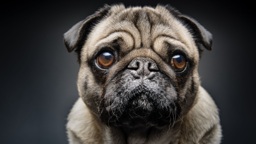

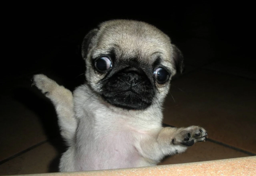

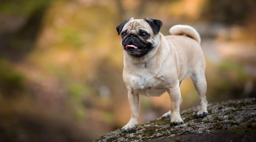

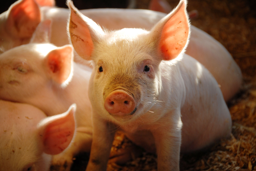

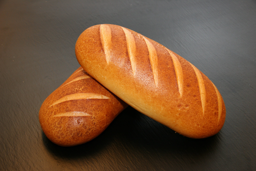

In [65]:
for term in results.keys():
    download_validation_image(term)

Load initial training data.  Use a small data set.

In [54]:
searches = ['dog','pig','loaf of bread']
path = Path('training_data')
from time import sleep

max_images=5

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'"{o}" photo', max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'"{o} in sun" photo', max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'"{o} in shade" photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for '"dog" photo'
Searching for '"dog in sun" photo'
Searching for '"dog in shade" photo'
Searching for '"pig" photo'
Searching for '"pig in sun" photo'
Searching for '"pig in shade" photo'
Searching for '"loaf of bread" photo'
Searching for '"loaf of bread in sun" photo'
Searching for '"loaf of bread in shade" photo'


Remove any invalid images.

In [55]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Build a data block for training with 20% of the data used for validation.

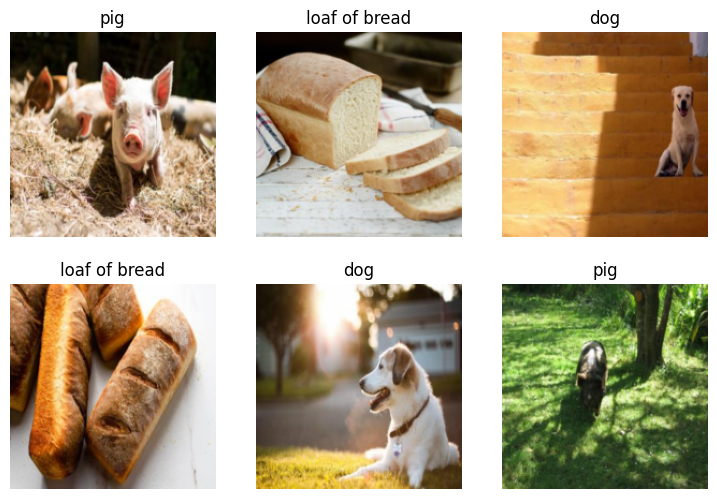

In [66]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [71]:
learn = vision_learner(dls, model, metrics=accuracy)
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.084897,3.278141,0.000000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.936980,2.418574,0.125000,00:04
1,1.738409,0.973399,0.375000,00:04
2,1.241076,0.437079,0.875000,00:04


In [126]:
def check_category(test_name):
    for term in results.keys():
        # get the prediction
        dest=f"validation_data/{term}.jpg"
        category,category_num,probs = learn.predict(PILImage.create(dest))
        # show prediction
        print(f"This is a: {category}")
        print(f"Probability it's a {category}: {probs[category_num]:.4f}")
        # show image
        im = Image.open(dest)
        display(im.to_thumb(256,256))
        # save data for later
        if test_name not in results[term]:
            results[term][test_name] = {
                "category": "",
                "probability": "",
            }
        results[term][test_name]['category'] = category
        results[term][test_name]['probability'] = f"{probs[category_num]:.4f}"

This is a: dog
Probability it's a dog: 0.7171


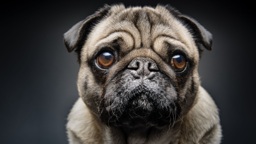

This is a: dog
Probability it's a dog: 0.9985


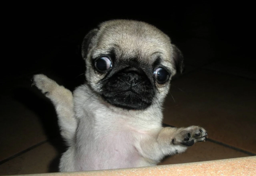

This is a: dog
Probability it's a dog: 1.0000


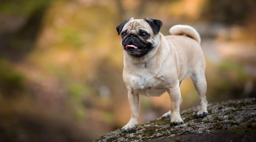

This is a: pig
Probability it's a pig: 1.0000


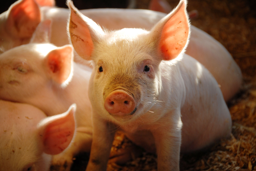

This is a: loaf of bread
Probability it's a loaf of bread: 0.9998


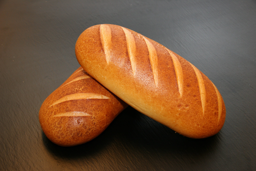

In [130]:
check_category("images=5,epochs=3")

How well did your model predict the right answer?

What happens if we add more images or train for more iterations?

# Revision: train more!

In [86]:
learn = vision_learner(dls, model, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.686391,1.900758,0.625000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.730813,1.133154,0.500000,00:04
1,1.559075,0.790905,0.250000,00:04
2,1.129847,0.594870,0.125000,00:04
3,0.867415,0.441437,0.125000,00:04
4,0.692246,0.367085,0.125000,00:04
5,0.573938,0.323454,0.125000,00:04
6,0.492816,0.277282,0.125000,00:04
7,0.427986,0.243162,0.125000,00:04
8,0.377374,0.224513,0.125000,00:04
9,0.336834,0.215309,0.125000,00:04


This is a: dog
Probability it's a dog: 0.7803


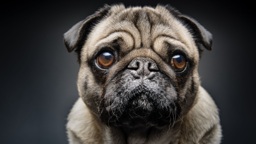

This is a: dog
Probability it's a dog: 0.8243


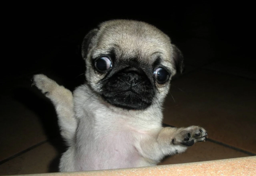

This is a: dog
Probability it's a dog: 0.9866


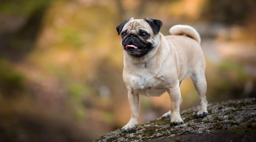

This is a: pig
Probability it's a pig: 0.9997


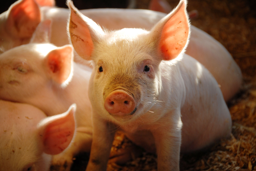

This is a: loaf of bread
Probability it's a loaf of bread: 0.9984


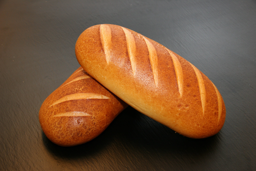

In [87]:
check_category("images=5,epochs=10")

What if we also bump up the amount of data?

# Revision: more data!!

Bump the set of data we collect up from 5 per bucket to 30.  Train the model with even more epochs.  Validate

In [90]:
# only more data for dog, pig, and loaf of bread
searches = ['dog','pig','loaf of bread']

max_images = 30

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'"{o}" photo', max_images))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'"{o} in sun" photo', max_images))
    sleep(10)
    download_images(dest, urls=search_images(f'"{o} in shade" photo', max_images))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for '"dog" photo'
Searching for '"dog in sun" photo'
Searching for '"dog in shade" photo'
Searching for '"pig" photo'
Searching for '"pig in sun" photo'
Searching for '"pig in shade" photo'
Searching for '"loaf of bread" photo'
Searching for '"loaf of bread in sun" photo'
Searching for '"loaf of bread in shade" photo'


In [93]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

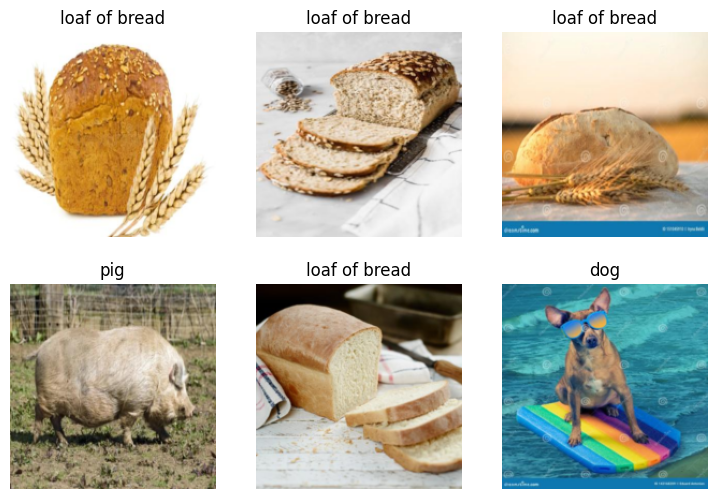

In [96]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [97]:
learn = vision_learner(dls, model, metrics=accuracy)
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.620153,0.429846,0.820000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.288615,0.205638,0.920000,00:15
1,0.176453,0.100004,0.980000,00:15
2,0.123208,0.089124,0.980000,00:15
3,0.088836,0.187053,0.920000,00:15
4,0.068642,0.196361,0.920000,00:15
5,0.056968,0.150061,0.980000,00:15
6,0.049263,0.150576,0.980000,00:15
7,0.040400,0.143004,0.940000,00:15
8,0.033774,0.140901,0.940000,00:15
9,0.028430,0.143323,0.940000,00:15


This is a: dog
Probability it's a dog: 0.7171


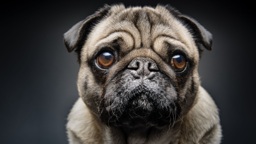

This is a: dog
Probability it's a dog: 0.9985


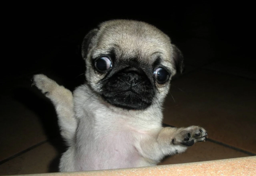

This is a: dog
Probability it's a dog: 1.0000


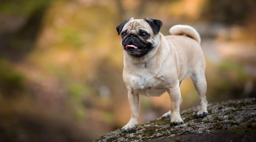

This is a: pig
Probability it's a pig: 1.0000


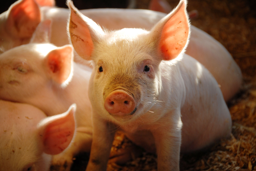

This is a: loaf of bread
Probability it's a loaf of bread: 0.9998


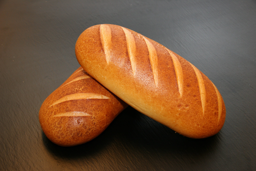

In [98]:
check_category("images=30,epochs=10")

Was the prediction any better?

In [134]:
import pandas as pd
col=[] # use list so we keep order
data = {}
for term in results.keys():
    if term not in data:
        data[term] = []
    for test in results[term]:
        if test not in col:
            col.append(test)
        data[term].append(f"{results[term][test]['category']} ({float(results[term][test]['probability'])*100:.0f}%)")
pd.DataFrame(data.values(), index=data.keys(), columns=list(col))

,"images=5,epochs=3","images=5,epochs=10","images=30,epochs=10"
pug face,dog (72%),dog (78%),dog (72%)
cute pug face,dog (100%),dog (82%),dog (100%)
pug full body adult on tree,dog (100%),dog (99%),dog (100%)
pig,pig (100%),pig (100%),pig (100%)
bread,loaf of bread (100%),loaf of bread (100%),loaf of bread (100%)


Results may vary depending on the training.  I saw cases where pugs images were classified as pigs or bread.

The point of this exercies isn't to get a correct result, but to play around with some vison learning models, modifying some parameters and seeing how the results change.  The fact that training the model on a larger data set for a longer period of time (in my example) resulted in a worse prediction is just the icing on the cake.

I hope you learned something and had a fun time.  If you're results are different, amusing, or you tried something else and got an interesting result please let me know.

In [129]:
results

{'pug face': {'images=5,epochs=3': {'category': 'dog', 'probability': '71.71'},
  'images=5,epochs=10': {'category': 'dog', 'probability': '0.7803'},
  'images=30,epochs=10': {'category': 'dog', 'probability': '0.7171'}},
 'cute pug face': {'images=5,epochs=3': {'category': 'dog',
   'probability': '99.85'},
  'images=5,epochs=10': {'category': 'dog', 'probability': '0.8243'},
  'images=30,epochs=10': {'category': 'dog', 'probability': '0.9985'}},
 'pug full body adult on tree': {'images=5,epochs=3': {'category': 'dog',
   'probability': '100.00'},
  'images=5,epochs=10': {'category': 'dog', 'probability': '0.9866'},
  'images=30,epochs=10': {'category': 'dog', 'probability': '1.0000'}},
 'pig': {'images=5,epochs=3': {'category': 'pig', 'probability': '100.00'},
  'images=5,epochs=10': {'category': 'pig', 'probability': '0.9997'},
  'images=30,epochs=10': {'category': 'pig', 'probability': '1.0000'}},
 'bread': {'images=5,epochs=3': {'category': 'loaf of bread',
   'probability': '99.9